**Instructions**

Run the notebook to load the pretrained model and see evaluations or train a new model  
This code was adapted from https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html where marked "(see ref above)", otherwise it is original

In [1]:
#magic functions to help load external modules
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from PIL import Image
import os
import re

In [3]:
#(see ref above)
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter
from torchtext.vocab import Vocab

In [4]:
%%capture
from tqdm.notebook import tqdm
tqdm().pandas()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

In [5]:
from F8_utils import *

In [6]:
#import pre-prepared data
df = pd.read_csv('text_emotion_cleaned.csv', dtype={'tweet_without_stopwords': str})
df['content']=df['tweet_without_stopwords'].astype('str')
df['label'] = pd.factorize(df['sentiment'])[0].astype(np.uint16) #add numerical class labels

#split dataset into training, validation and testing sets
df_train = df.iloc[:32000]
df_valid = df.iloc[32000:36000]
df_test = df.iloc[36000:40000]

In [7]:
df_train

,Unnamed: 0,tweet_id,sentiment,author,content,tweet_without_stopwords,label
0,0,1956967341,empty,xoshayzers,know listenin habit earlier started freakin part,know listenin habit earlier started freakin part,0
1,1,1956967666,sadness,wannamama,Layin headache ughhhh...waitin call...,Layin headache ughhhh...waitin call...,1
2,2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,1
3,3,1956967789,enthusiasm,czareaquino,wants hang friends SOON!,wants hang friends SOON!,2
4,4,1956968416,neutral,xkilljoyx,"want trade someone Houston tickets, will.","want trade someone Houston tickets, will.",3
...,...,...,...,...,...,...,...
31995,31995,1752157021,worry,KuraFire,kind figured. He'd probably unable reason thin...,kind figured. He'd probably unable reason thin...,4
31996,31996,1752157024,relief,greenteacup,"Going town friend, long time seen him...OKOK.....","Going town friend, long time seen him...OKOK.....",11
31997,31997,1752157027,sadness,sweet_dreams_09,"caught rain. Sand Monsoon home, even though lo...","caught rain. Sand Monsoon home, even though lo...",1
31998,31998,1752157030,relief,1Handprint,Time weapons charger night. Sleep tight,Time weapons charger night. Sleep tight,11


In [8]:
#define classes for model
classes = list(df['sentiment'].unique())
classes

['empty',
 'sadness',
 'enthusiasm',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief',
 'anger']

**DATASET DISTRIBUTION**




In [9]:
class FigureEight(Dataset):  #define dataset class
    
    def __init__(self, df):
        super().__init__()
        self.df=df
        self.classes = classes
        self.sort_key=False
        self.fields = {'content':df['content'], 'label':df['label']}
                                            
    def __len__(self):  
        return len(self.df)
                                            
    def __getitem__(self, idx):
        X = self.df['content'].iloc[idx]                         
        y = self.df['label'].iloc[idx]                                  

        return idx,X,y   

In [10]:
#create Pytorch datasets
trainset=FigureEight(df_train)
valset=FigureEight(df_valid)
testset=FigureEight(df_test)

In [11]:
#define tokenizer function (see ref above)
tokenizer = get_tokenizer('basic_english')
def yield_tokens(trainset):
    for i in range (len(trainset)):
        _, text, _ = trainset[i]
        yield tokenizer(text)

In [12]:
#build vocabulary (see ref above)
vocab = build_vocab_from_iterator(yield_tokens(trainset), specials=["<unk>"], min_freq=2)
vocab.set_default_index(vocab["<unk>"])

In [13]:
len(vocab)

10553

In [14]:
#create model (see ref above) but with the addition of another linear layer and Relu activation to boost accuracy

from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False) # embedding bag layer
        self.fc1 = nn.Linear(embed_dim, 2*embed_dim)#first linear layer
        self.fc2 = nn.Linear(2*embed_dim, num_class)#second linear layer
        self.init_weights() 

    def init_weights(self): # initiate weights within a 0.5 range around zero to support training
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        x = torch.relu(self.fc1(embedded)) # use relu evalutation between linear layers
        return self.fc2(x) 

In [15]:
#collate batches of tweets along with offsets so the model know where each one starts and finishes
#(see ref above) but amended also to take idx
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (idx, text, label) in batch:
         label_list.append(label_pipeline(label))
         processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)    

In [16]:
#define function to run vocab items through tokenizer when needed
def text_pipeline(X): 
        return [vocab[token] for token in tokenizer(X)]   

In [17]:
#create dataloaders
trainloader=DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=collate_batch)
valloader=DataLoader(valset, batch_size=512, shuffle=True, collate_fn=collate_batch)
testloader=DataLoader(testset, batch_size=512, shuffle=True, collate_fn=collate_batch)

In [18]:
#define hyperparameters and create network
num_class = len(df['label'].unique())
vocab_size = len(vocab)
emsize = 64
net = TextClassificationModel(vocab_size, emsize, num_class).to(device)
net.to(device)
net.train()

TextClassificationModel(
  (embedding): EmbeddingBag(10553, 64, mode=mean)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
)

In [19]:
#load pretrained model (or comment out to train from scratch instead)
load_checkpoint('embed_bag_model_weights_FINAL.pth', net, device)

Model's pretrained weights loaded!


In [20]:
#load loss and accuracy histories from model training as pre-loaded, or train a new model
my_histories = np.load('embed_bag_histories.npy')
loss = my_histories[0]
train_acc = my_histories[2]
valid_loss = my_histories[1]
valid_acc = my_histories[3]

In [21]:
# training parameters if deciding to train
n_epochs = 25
lr=0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [22]:
# training function if deciding to train

In [23]:
# def train():
#     loss_history=[]
#     valid_loss_history=[]
#     train_acc_history=[]
#     val_acc_history = []
#     best_acc=60
#     accuracy=0
#     for e in tqdm(range(n_epochs)):
#         for idx, (label, text, offsets) in enumerate(trainloader):
#                 for param in net.parameters(): #zero the gradients
#                     param.grad = None
#                 predited_label = net(text, offsets) #get prediction
#                 loss = criterion(predited_label, label) #calculate loss
#                 loss.backward() # backpropagate
#                 torch.nn.utils.clip_grad_norm_(net.parameters(), 0.1) # clip gradients to aide learning
#                 optimizer.step() # update optimizer
#         #get evaluation scores
#         with torch.no_grad():
#             net.eval() # put into evaluation mode
#             for idx, (label, text, offsets) in enumerate(valloader):
#                 predited_label = net(text, offsets)
#                 valid_loss = criterion(predited_label, label)
#             conf_matrix = make_conf_matrix(net, valloader, device)
#             val_acc  = get_accuracy(conf_matrix)
#             conf_matrix = make_conf_matrix(net, trainloader, device)
#             train_acc  = get_accuracy(conf_matrix)
#             loss=loss.detach().cpu().numpy().item()
#             valid_loss = valid_loss.detach().cpu().numpy().item()
#             loss_history.append(loss)
#             valid_loss_history.append(valid_loss)
#             val_acc_history.append (val_acc)
#             train_acc_history.append (train_acc)
#         #save model if validation accuracy improves on best
#         if val_acc>best_acc:
#             acc_string=str(val_acc.round(3))
#             acc_string.replace(".", "_") 
#             torch.save(net.state_dict(), acc_string+'weights'+'.pth')
#             best_acc=val_acc
#         print('eph=',e, 'trainloss=',loss/len(trainloader), 'trainacc=',train_acc, 'validloss=',valid_loss/len(valloader),'valacc=',val_acc)
#     return loss_history, train_acc_history, valid_loss_history, val_acc_history 

In [24]:
# loss, train_acc, valid_loss, valid_acc = train()

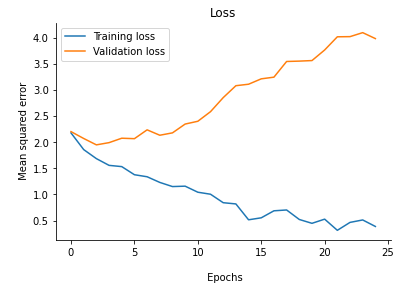

In [25]:
# Loss plot from training
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.xlabel('\n Epochs')
plt.ylabel('\n Mean squared error')
plt.plot(loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.title('Loss')
plt.legend()

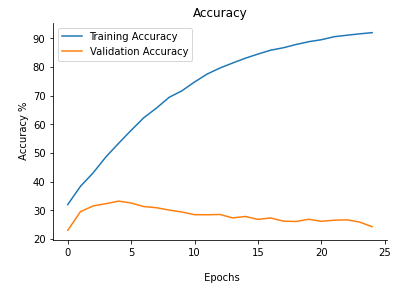

In [26]:
#accuracy plot from training
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('\n Epochs')
plt.ylabel('\n Accuracy %')
plt.title('Accuracy')
plt.legend()

In [27]:
#create confusion matrices for training and testsets
train_cm = make_conf_matrix(net, trainloader, device)
test_cm = make_conf_matrix(net, testloader, device)

In [28]:
#import seaborn visualisation library
import seaborn as sns

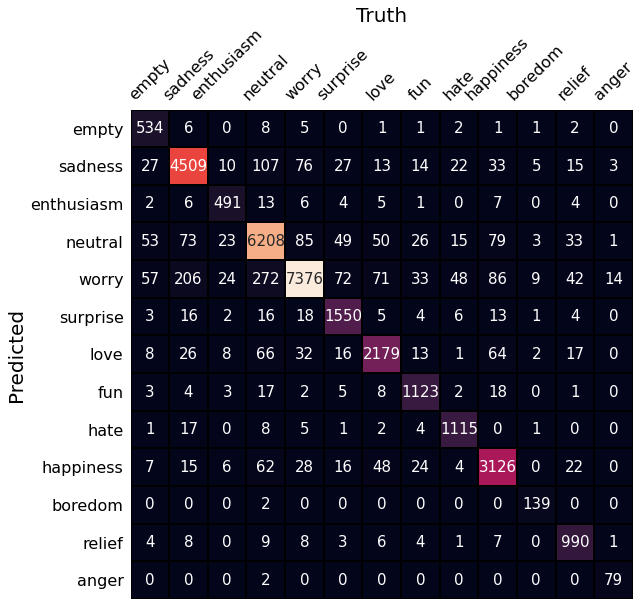

In [29]:
#plot training confusion matrix
plot_conf_matrix(train_cm)

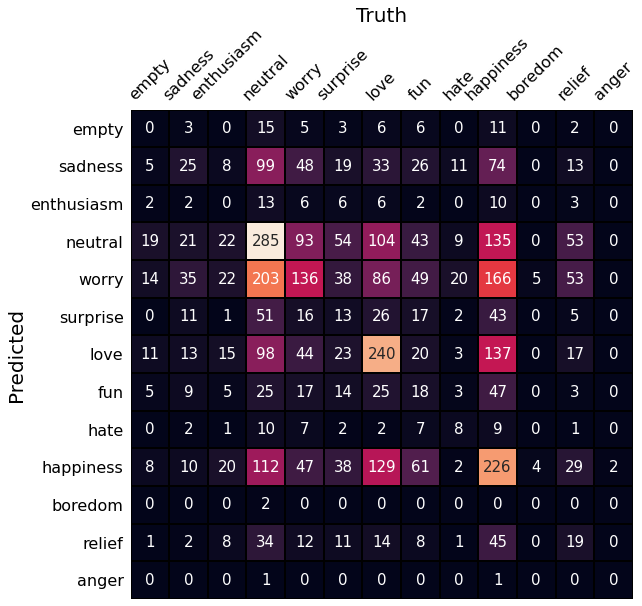

In [30]:
#plot testset confusion matrix
plot_conf_matrix(test_cm)

In [31]:
#get evaluation scores on the training set
get_eval_scores(train_cm)

Accuracy = 91.9 %


,hate,sadness,worry,fun,neutral,boredom,happiness,surprise,relief,love,enthusiasm,anger,empty
F1 Score,0.941,0.925,0.925,0.923,0.921,0.921,0.920,0.917,0.912,0.904,0.888,0.883,0.848
Precision,0.966,0.928,0.888,0.947,0.927,0.986,0.931,0.946,0.951,0.896,0.911,0.975,0.952
Recall,0.917,0.923,0.965,0.901,0.914,0.863,0.910,0.889,0.876,0.912,0.866,0.806,0.764
